# Predicting Hospital Readmissions for Diabetic Patients

## Problem statement and justification for the proposed approach

Hospital readmissions are costly for both healthcare systems and patients, particularly for chronic conditions like diabetes. 
- For patients: readmissions are stressful, costly, disruptive, and potentially dangerous, particularly for those managing chronic conditions like diabetes

- For hospitals and providers: readmissions carry significant financial consequences. In 2014, the Centers for Medicare & Medicaid Services (CMS) issued penalties to 2,610 hospitals for excessive 30-day readmissions under the Hospital Readmissions Reduction Program (HRRP).  (Smith et al. 2021)

- Patients diagnosed with diabetes face even higher readmission rates, ranging from 14.4% to 22.7%, compared to the general population.  (Smith et al. 2021)

- According to the Agency for Healthcare Research and Quality (AHRQ), a modest 5% reduction in readmissions could lead to fewer admissions per year, translating to over $1.2 billion in annual cost savings.  (Smith et al. 2021)

- Reducing readmission rates is a key quality metric in value-based healthcare. 

Given these clinical and financial stakes, the ability to accurately predict which diabetic patients are at high risk of readmission at the time of discharge is critical. Such insight would allow healthcare systems to proactively intervene with targeted follow-up care, care coordination, and risk mitigation strategies.

### Proposed Approach
This project proposes a supervised machine learning solution trained on a rich dataset of real-world electronic health records (EHR) collected from over 130 U.S. hospitals between 1999–2008. Our goal is to:

- Develop a predictive model for 30-day readmission risk in diabetic patients.

- Ensure the model is interpretable and production ready supporting real-time clinical use.

- Enable providers to integrate the model into EHR workflows, identifying high-risk discharges and triggering appropriate post-discharge protocols such as early follow-up scheduling or care management outreach.

Predictive modeling enables hospitals to proactively identify high-risk patients at the time of discharge, rather than reacting after costly readmissions occur. Given the dataset’s characteristics—including mixed data types (categorical and numeric), missing values, and class imbalance, we explore ensemble tree-based methods like XGBoost and CatBoost, which are particularly well-suited for high cardinality categorical features, and offer interpretability. 

References:

Smith, J., Jones, A., et al. (2021). Explainable machine learning for hospital readmission prediction among diabetes patients. BMC Medical Informatics and Decision Making. https://doi.org/10.1186/s12911-021-01423-y


## Data Understanding (EDA)


- Records from ~100,000 hospital encounters
- Target: Readmitted within 30 days (readmitted_binary)
- Mix of numeric (e.g., num_lab_procedures) and categorical (e.g., discharge_disposition_id, insulin) features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score
from catboost import CatBoostClassifier, Pool
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        print("Data loaded successfully.")
        print(f"Dataset shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

# Load the diabetic readmission dataset
data_path = "diabetic_data.csv"
df = load_data(data_path)

print("\nCOLUMN DATA TYPES:")
print(df.dtypes.value_counts())

print("\nBASIC STATISTICS:")
print(df.describe())

df.head()


Data loaded successfully.
Dataset shape: (101766, 50)

COLUMN DATA TYPES:
object    37
int64     13
Name: count, dtype: int64

BASIC STATISTICS:
       encounter_id   patient_nbr  admission_type_id  \
count  1.017660e+05  1.017660e+05      101766.000000   
mean   1.652016e+08  5.433040e+07           2.024006   
std    1.026403e+08  3.869636e+07           1.445403   
min    1.252200e+04  1.350000e+02           1.000000   
25%    8.496119e+07  2.341322e+07           1.000000   
50%    1.523890e+08  4.550514e+07           1.000000   
75%    2.302709e+08  8.754595e+07           3.000000   
max    4.438672e+08  1.895026e+08           8.000000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101766.000000        101766.000000     101766.000000   
mean                   3.715642             5.754437          4.395987   
std                    5.280166             4.064081          2.985108   
min                    1.000000             1.000000  

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Missing Values Analysis


MISSING VALUES ANALYSIS

Missing Values Summary:
           Column  Missing_Count  Missing_Percentage
           weight          98569           96.858479
    max_glu_serum          96420           94.746772
        A1Cresult          84748           83.277322
medical_specialty          49949           49.082208
       payer_code          40256           39.557416
             race           2273            2.233555
           diag_3           1423            1.398306
           diag_2            358            0.351787
           diag_1             21            0.020636


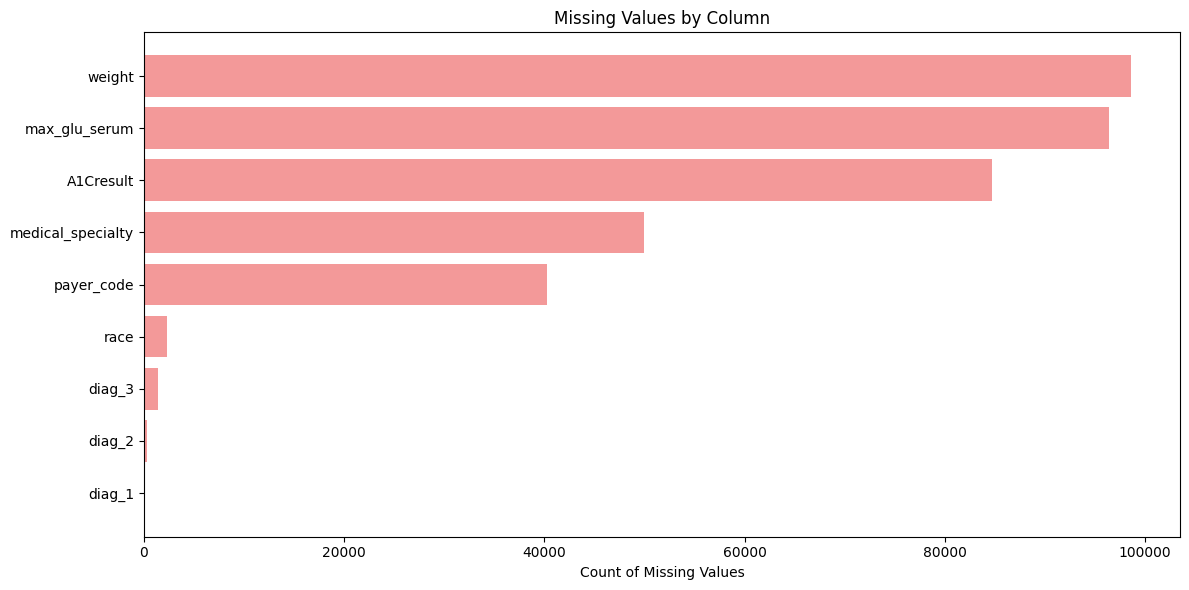

(        encounter_id  patient_nbr             race  gender      age weight  \
 0            2278392      8222157        Caucasian  Female   [0-10)    NaN   
 1             149190     55629189        Caucasian  Female  [10-20)    NaN   
 2              64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
 3             500364     82442376        Caucasian    Male  [30-40)    NaN   
 4              16680     42519267        Caucasian    Male  [40-50)    NaN   
 ...              ...          ...              ...     ...      ...    ...   
 101761     443847548    100162476  AfricanAmerican    Male  [70-80)    NaN   
 101762     443847782     74694222  AfricanAmerican  Female  [80-90)    NaN   
 101763     443854148     41088789        Caucasian    Male  [70-80)    NaN   
 101764     443857166     31693671        Caucasian  Female  [80-90)    NaN   
 101765     443867222    175429310        Caucasian    Male  [70-80)    NaN   
 
         admission_type_id  discharge_disposition_

In [4]:
# =====================================
# MISSING VALUES ANALYSIS
# =====================================

def analyze_missing_values(df):
    """Comprehensive missing values analysis"""
    print("\n" + "="*50)
    print("MISSING VALUES ANALYSIS")
    print("="*50)

     # Replace '?' with np.nan for true missing value detection
    df = df.replace('?', np.nan).copy()
    
    # Calculate missing values
    missing_data = df.isnull().sum()
    missing_percent = 100 * missing_data / len(df)
    
    # Create missing values summary
    missing_summary = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': missing_percent.values
    })
    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
    
    # Display summary
    if missing_summary.empty:
        print("No missing values found in the dataset.")
    else:
        print("\nMissing Values Summary:")
        print(missing_summary.to_string(index=False))
    
        # Visualize missing values
        plt.figure(figsize=(12, 6))
        plt.barh(
            missing_summary['Column'], 
            missing_summary['Missing_Count'], 
            color='lightcoral', alpha=0.8
        )
        plt.xlabel('Count of Missing Values')
        plt.title('Missing Values by Column')
        plt.gca().invert_yaxis()  # Show largest at top
        plt.tight_layout()
        plt.show()

    return df, missing_summary

analyze_missing_values(df)

### Target variable analysis


Analyzing the target variable, readmitted. Readmitted is a categorical variable with 3 levels: >30, <30, and NO. For value based care, we care if they are readmitted within 30 days. So converting the target variable to a binary variable.


TARGET VARIABLE ANALYSIS
Original Target Variable Distribution:
  NO: 54,864 (53.91%)
  >30: 35,545 (34.93%)
  <30: 11,357 (11.16%)

Binary Target Variable Distribution (Focus: <30 days):
  0 (NO or >30): 90,409 (88.84%)
  1 (<30): 11,357 (11.16%)


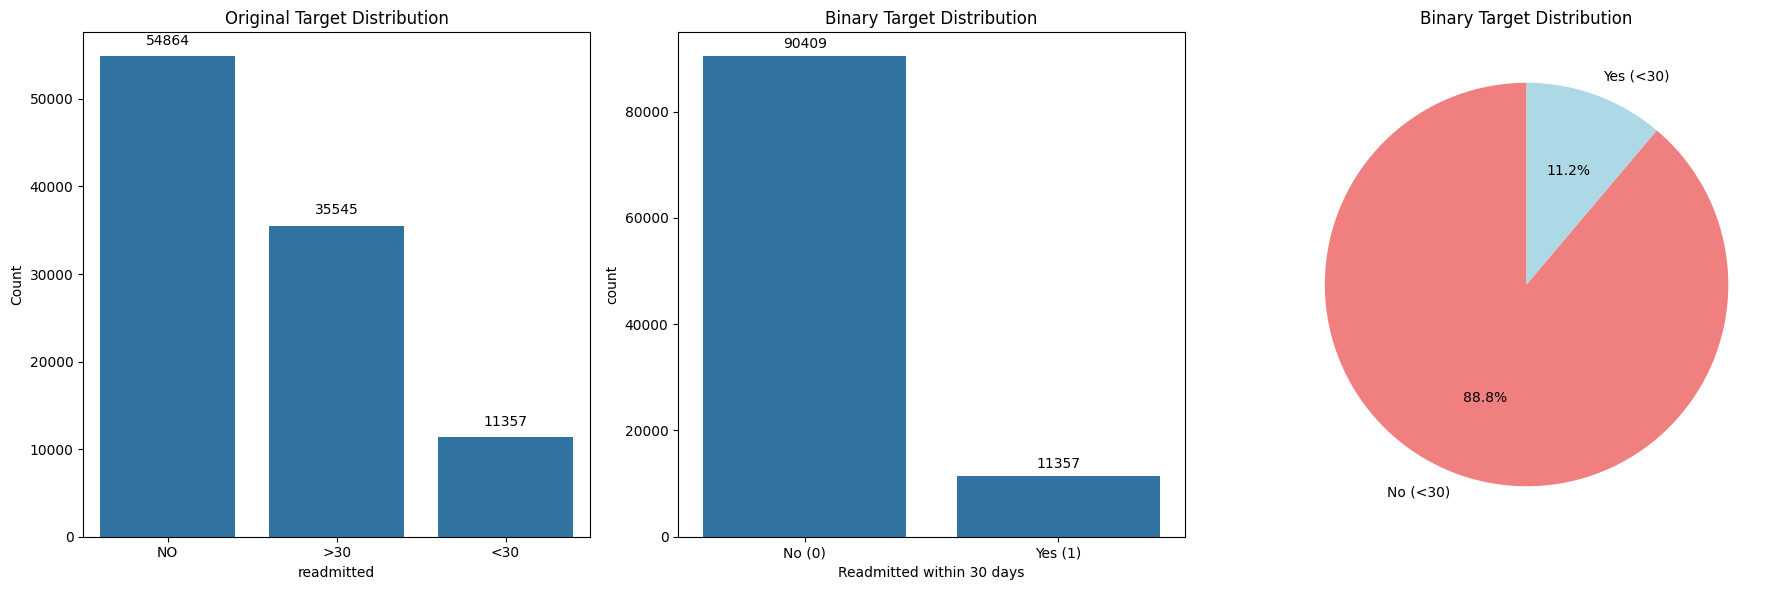

In [5]:
def analyze_target_variable(df, target_col='readmitted'):
    """Analyze the target variable distribution"""
    print("\n" + "="*50)
    print("TARGET VARIABLE ANALYSIS")
    print("="*50)
    
    # Original target variable distribution
    target_counts = df[target_col].value_counts()
    target_percentages = df[target_col].value_counts(normalize=True) * 100
    
    print("Original Target Variable Distribution:")
    for value in target_counts.index:
        print(f"  {value}: {target_counts[value]:,} ({target_percentages[value]:.2f}%)")
    
    # Create binary target: 1 for <30 (readmitted within 30 days), 0 for others
    df['readmitted_binary'] = (df[target_col] == '<30').astype(int)
    
    # Binary target distribution
    binary_counts = df['readmitted_binary'].value_counts()
    binary_percentages = df['readmitted_binary'].value_counts(normalize=True) * 100
    
    print("\nBinary Target Variable Distribution (Focus: <30 days):")
    print(f"  0 (NO or >30): {binary_counts[0]:,} ({binary_percentages[0]:.2f}%)")
    print(f"  1 (<30): {binary_counts[1]:,} ({binary_percentages[1]:.2f}%)")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original distribution
    sns.countplot(data=df, x=target_col, ax=axes[0])
    axes[0].set_title('Original Target Distribution')
    axes[0].set_ylabel('Count')
    for i, v in enumerate(target_counts.values):
        axes[0].text(i, v + 1000, str(v), ha='center', va='bottom')
    
    # Binary distribution
    sns.countplot(data=df, x='readmitted_binary', ax=axes[1])
    axes[1].set_title('Binary Target Distribution')
    axes[1].set_xlabel('Readmitted within 30 days')
    axes[1].set_xticklabels(['No (0)', 'Yes (1)'])
    for i, v in enumerate(binary_counts.values):
        axes[1].text(i, v + 1000, str(v), ha='center', va='bottom')
    
    # Pie chart for binary
    axes[2].pie(binary_counts.values, labels=['No (<30)', 'Yes (<30)'], 
               autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
    axes[2].set_title('Binary Target Distribution')
    
    plt.tight_layout()
    plt.show()
        
    return target_counts, binary_counts

# Run target variable analysis
if df is not None:
    target_analysis, binary_analysis = analyze_target_variable(df)

#### Target Variable Analysis Notes
The dataset is severely imbalanced with only ~11% of the patients readmitted to the hospital within 30 days. Balancing techniques will need to be used to address this.

### Numerical Features Analysis


NUMERICAL VARIABLES ANALYSIS
Numerical columns (9): ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'readmitted_binary']

Statistical Summary:
       time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count         101766.00           101766.00       101766.00        101766.00   
mean               4.40               43.10            1.34            16.02   
std                2.99               19.67            1.71             8.13   
min                1.00                1.00            0.00             1.00   
25%                2.00               31.00            0.00            10.00   
50%                4.00               44.00            1.00            15.00   
75%                6.00               57.00            2.00            20.00   
max               14.00              132.00            6.00            81.00   

       number_outpatie

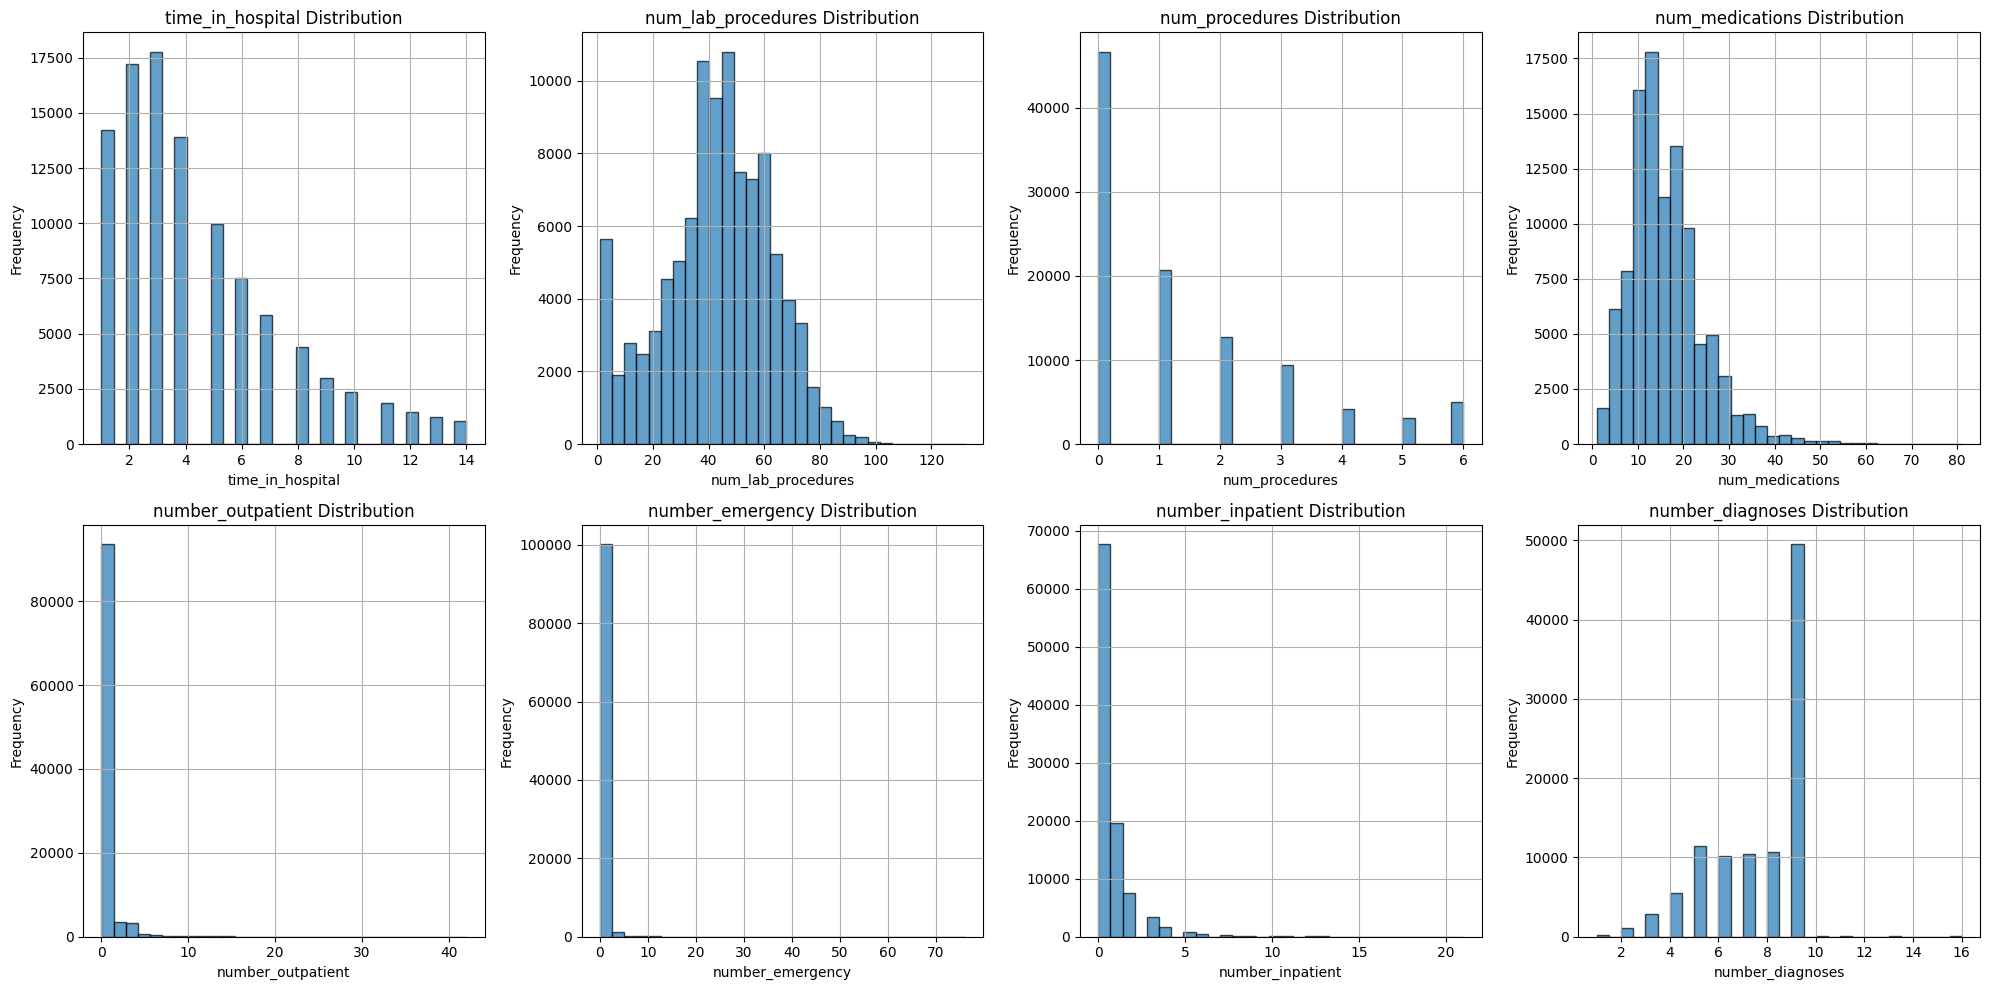

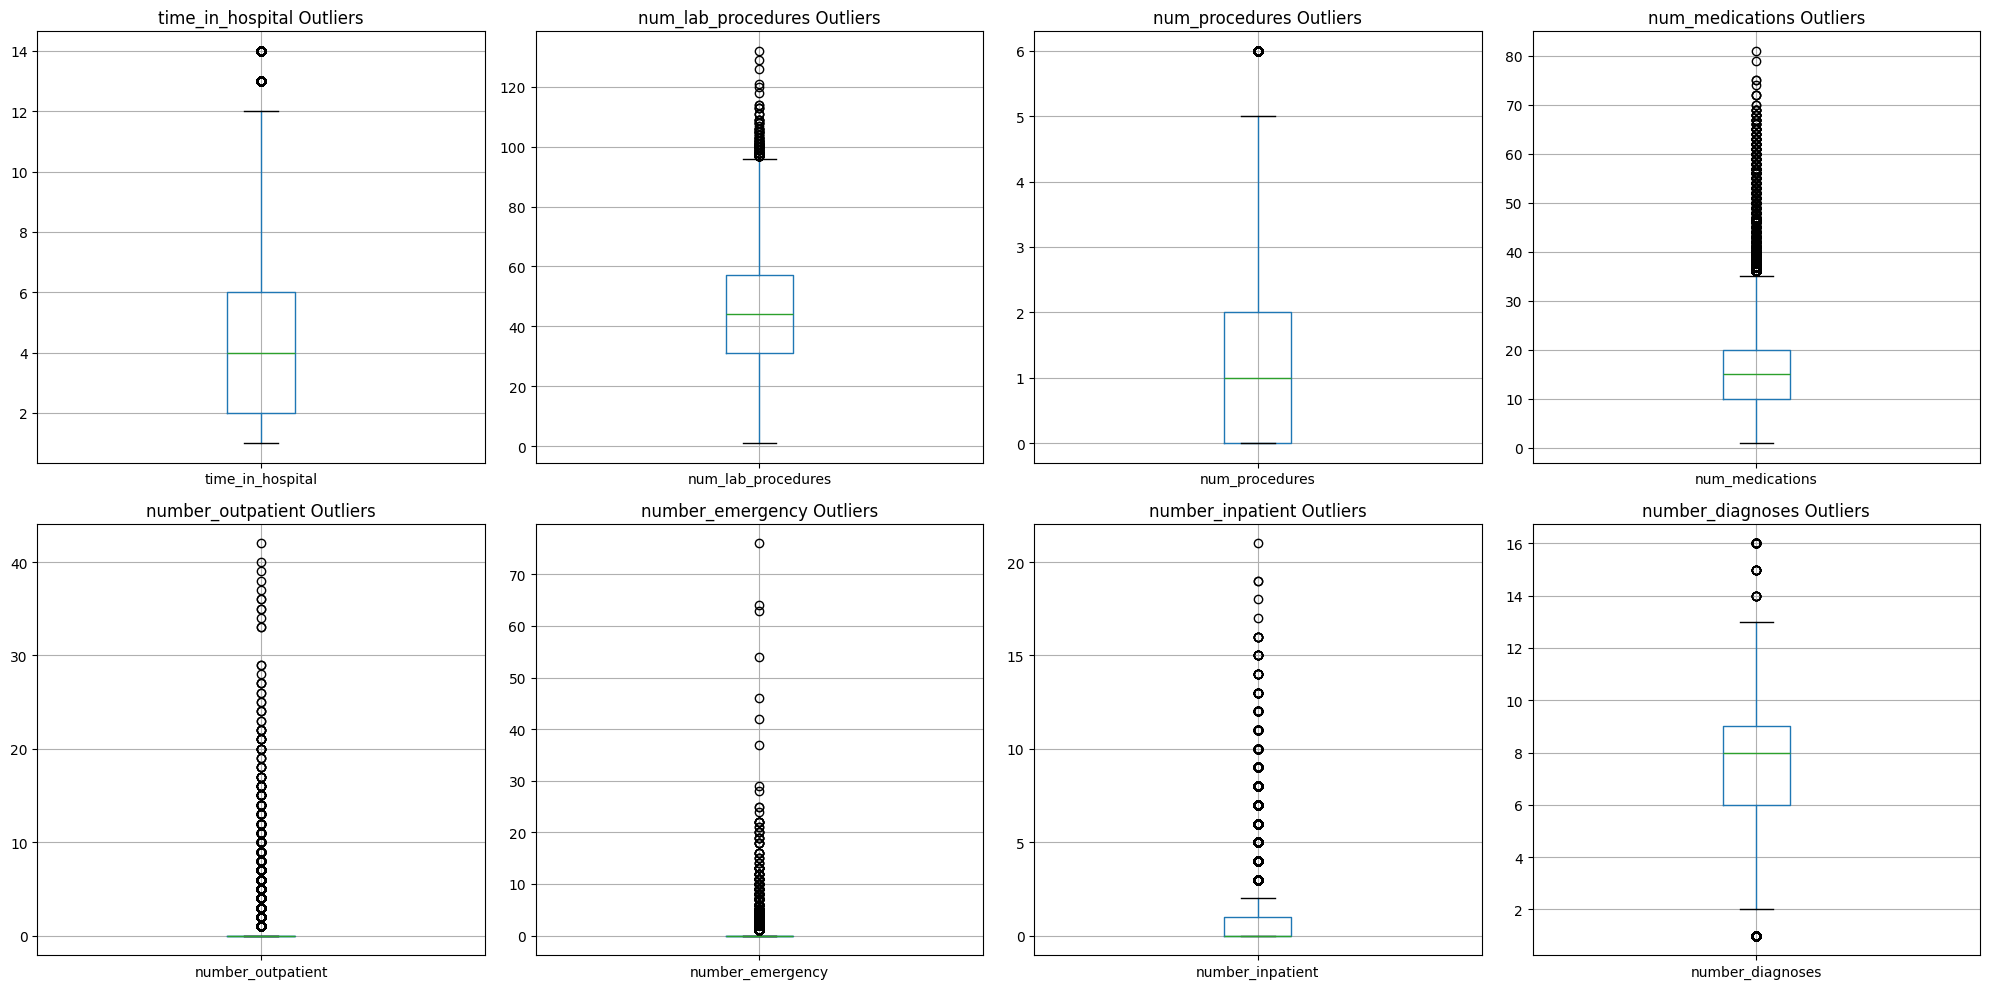

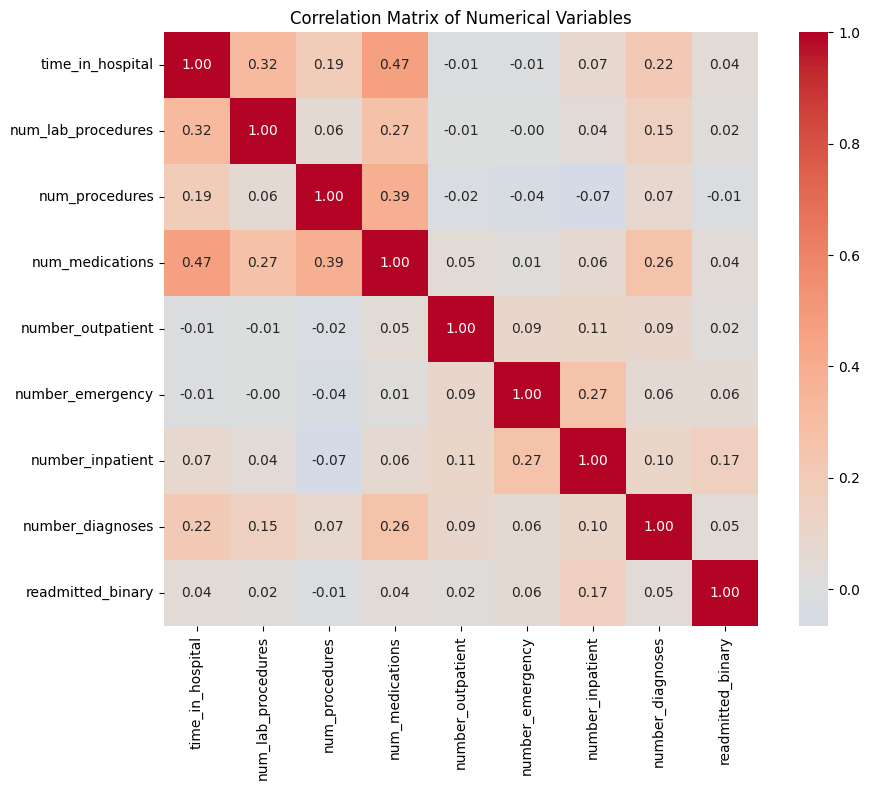

In [6]:
def analyze_numerical_variables(df):
    """Analyze numerical variables for modeling insights"""
    print("\n" + "="*50)
    print("NUMERICAL VARIABLES ANALYSIS")
    print("="*50)
    
    # Identify numerical columns (exclude ID columns)
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if 'id' not in col.lower() and 'nbr' not in col.lower()]
    
    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    
    # Statistical summary
    print("\nStatistical Summary:")
    print(df[numerical_cols].describe().round(2))
    
    # Distribution plots
    n_cols = len(numerical_cols)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            df[col].hist(bins=30, ax=axes[i], alpha=0.7, edgecolor='black')
            axes[i].set_title(f'{col} Distribution')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Box plots for outlier detection
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for i, col in enumerate(numerical_cols):
        if i < len(axes):
            df.boxplot(column=col, ax=axes[i])
            axes[i].set_title(f'{col} Outliers')
    
    plt.tight_layout()
    plt.show()
    
    # Correlation matrix
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numerical_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f')
    plt.title('Correlation Matrix of Numerical Variables')
    plt.tight_layout()
    plt.show()
    
    return numerical_cols

# Run numerical analysis
if df is not None:
    numerical_features = analyze_numerical_variables(df)

#### Numerical Features Analysis Notes

- The target variable shows the strongest correlation with the following features (in descending order):
number_inpatient, number_emergency, number_diagnoses, time_in_hospital, and num_medications.

- The length of hospital stay is typically short, with the majority of patients staying between 2 to 4 days.

- The number of inpatient visits is generally low, with the majority of patients having 0 to 2 visits

- The number of medications is between 10-20 with the majority of the patients. 

- Most patients had no emergency visits recorded (number_emergency = 0).

- The number of diagnoses is commonly clustered around 6 to 8 diagnoses per patient.


### Categorical Features Analysis

In [7]:
# Map some categorical variables to named categories for easier analysis

admission_type_map = {
    1: "Emergency",
    2: "Urgent",
    3: "Elective",
    4: "Newborn",
    5: "Not Available",
    6: "NULL",
    7: "Trauma Center",
    8: "Not Mapped"
}

df['admission_type'] = df['admission_type_id'].map(admission_type_map)

discharge_disposition_map = {
    1: "Discharged to home",
    2: "To-short-term-hospital",
    3: "To SNF",
    4: "To ICF",
    5: "To other inpatient care",
    6: "Home w/ HS",
    7: "Left AMA",
    8: "Home under IV provider",
    9: "Admitted inpatient",
    10: "Neonate to another hospital",
    11: "Expired",
    12: "Still patient",
    13: "Hospice / home",
    14: "Hospice / facility",
    15: "To Medicare swing bed",
    16: "To outpatient (other inst.)",
    17: "To outpatient (this inst.)",
    18: "NULL",
    19: "Expired at home (Medicaid)",
    20: "Expired in facility (Medicaid)",
    21: "Expired, unknown place",
    22: "To rehab facility",
    23: "To long-term care hospital",
    24: "To Medicaid-only nursing",
    25: "Not Mapped",
    26: "Unknown/Invalid",
    27: "To federal facility",
    28: "To psychiatric hospital",
    29: "To Critical Access Hospital"
}



df['discharge_disposition'] = df['discharge_disposition_id'].map(discharge_disposition_map)

# Admission Type Mapping
admission_source_map = {
    1: 'Physician Referral',
    2: 'Clinic Referral',
    3: 'HMO Referral',
    4: 'Transfer from hospital',
    5: 'Transfer from SNF',
    6: 'Transfer from other ',
    7: 'Emergency Room',
    8: 'Court/Law Enforcement',
    9: 'Not Available',
    10: 'Transfer from critical access ',
    11: 'Normal Delivery',
    12: 'Premature Delivery',
    13: 'Sick Baby',
    14: 'Extramural Birth',
    15: 'Not Available',
    17: 'NULL',
    18: 'Transfer from another HHA',
    19: 'Readmission to same HHA',
    20: 'Not Mapped',
    21: 'Unknown/Invalid',
    22: 'Transfer within same facility',
    23: 'Born inside hospital',
    24: 'Born outside hospital',
    25: 'Transfer from Ambulatory Surgery Center',
    26: 'Transfer from Hospice'
}

df['admission_source'] = df['admission_source_id'].map(admission_source_map)


In [8]:
# There are some dicharge dispositions that are not relevant to our analysis, including expired and discharged to hospice, still patient exluding those from analysis
exclude_discharge_ids = [11, 12, 13, 14, 19, 20, 21]

# Filter dataframe to exclude these discharge types
df = df[~df['discharge_disposition_id'].isin(exclude_discharge_ids)].copy()


In [9]:
# Diagnoses mapping and analysis
# The diagnoses columns have ICD 9 codes and its large set. Mapping them to few categories will help us in analysis. 
# As defined in the paper, https://onlinelibrary.wiley.com/doi/10.1155/2014/781670, grouping them into broader categories. 

import re
# Define the groups and their ICD code ranges as tuples (start, end)
# For simplicity, codes like 250.xx are treated as 250 to 250.99
# 'E' and 'V' codes handled separately

# We'll convert codes to float for numeric ranges, and handle E, V codes as special.

def icd9_to_group(code):
    if pd.isna(code):
        return 'Unknown'
    code = str(code).strip()
    
    # Handle E and V codes separately
    if code.startswith('E'):
        return 'External causes of injury and supplemental classification'
    if code.startswith('V'):
        return 'External causes of injury and supplemental classification'
    
    # Extract numeric part before decimal
    match = re.match(r'(\d+)(?:\.(\d+))?', code)
    if not match:
        return 'Other/Unknown'
    
    main_code = int(match.group(1))
    # decimal_part = match.group(2) # we might use if needed
    
    # Map ranges from your table:
    if (390 <= main_code <= 459) or main_code == 785:
        return 'Circulatory'
    elif (460 <= main_code <= 519) or main_code == 786:
        return 'Respiratory'
    elif (520 <= main_code <= 579) or main_code == 787:
        return 'Digestive'
    elif main_code == 250:
        return 'Diabetes'
    elif 800 <= main_code <= 999:
        return 'Injury'
    elif 710 <= main_code <= 739:
        return 'Musculoskeletal'
    elif (580 <= main_code <= 629) or main_code == 788:
        return 'Genitourinary'
    elif 140 <= main_code <= 239:
        return 'Neoplasms'
    elif main_code in [780, 781, 784] or (790 <= main_code <= 799):
        return 'Other symptoms, signs, and ill-defined conditions'
    elif (240 <= main_code <= 279) and main_code != 250:
        return 'Endocrine, nutritional, and metabolic diseases (excluding diabetes)'
    elif (680 <= main_code <= 709) or main_code == 782:
        return 'Skin and subcutaneous tissue diseases'
    elif 1 <= main_code <= 139:
        return 'Infectious and parasitic diseases'
    elif 290 <= main_code <= 319:
        return 'Mental disorders'
    elif 280 <= main_code <= 289:
        return 'Blood diseases'
    elif 320 <= main_code <= 359:
        return 'Nervous system diseases'
    elif 630 <= main_code <= 679:
        return 'Pregnancy complications'
    elif 360 <= main_code <= 389:
        return 'Sense organs diseases'
    elif 740 <= main_code <= 759:
        return 'Congenital anomalies'
    else:
        return 'Other/Unknown'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col + '_group'] = df[col].apply(icd9_to_group)

# Example output check:
print(df[['diag_1', 'diag_1_group', 'diag_2', 'diag_2_group', 'diag_3', 'diag_3_group']].head())

   diag_1                                       diag_1_group  diag_2  \
0  250.83                                           Diabetes       ?   
1     276  Endocrine, nutritional, and metabolic diseases...  250.01   
2     648                            Pregnancy complications     250   
3       8                  Infectious and parasitic diseases  250.43   
4     197                                          Neoplasms     157   

    diag_2_group diag_3                                       diag_3_group  
0  Other/Unknown      ?                                      Other/Unknown  
1       Diabetes    255  Endocrine, nutritional, and metabolic diseases...  
2       Diabetes    V27  External causes of injury and supplemental cla...  
3       Diabetes    403                                        Circulatory  
4      Neoplasms    250                                           Diabetes  



CATEGORICAL VARIABLES ANALYSIS
Categorical columns (42): ['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'admission_type', 'discharge_disposition', 'admission_source', 'diag_1_group', 'diag_2_group', 'diag_3_group']


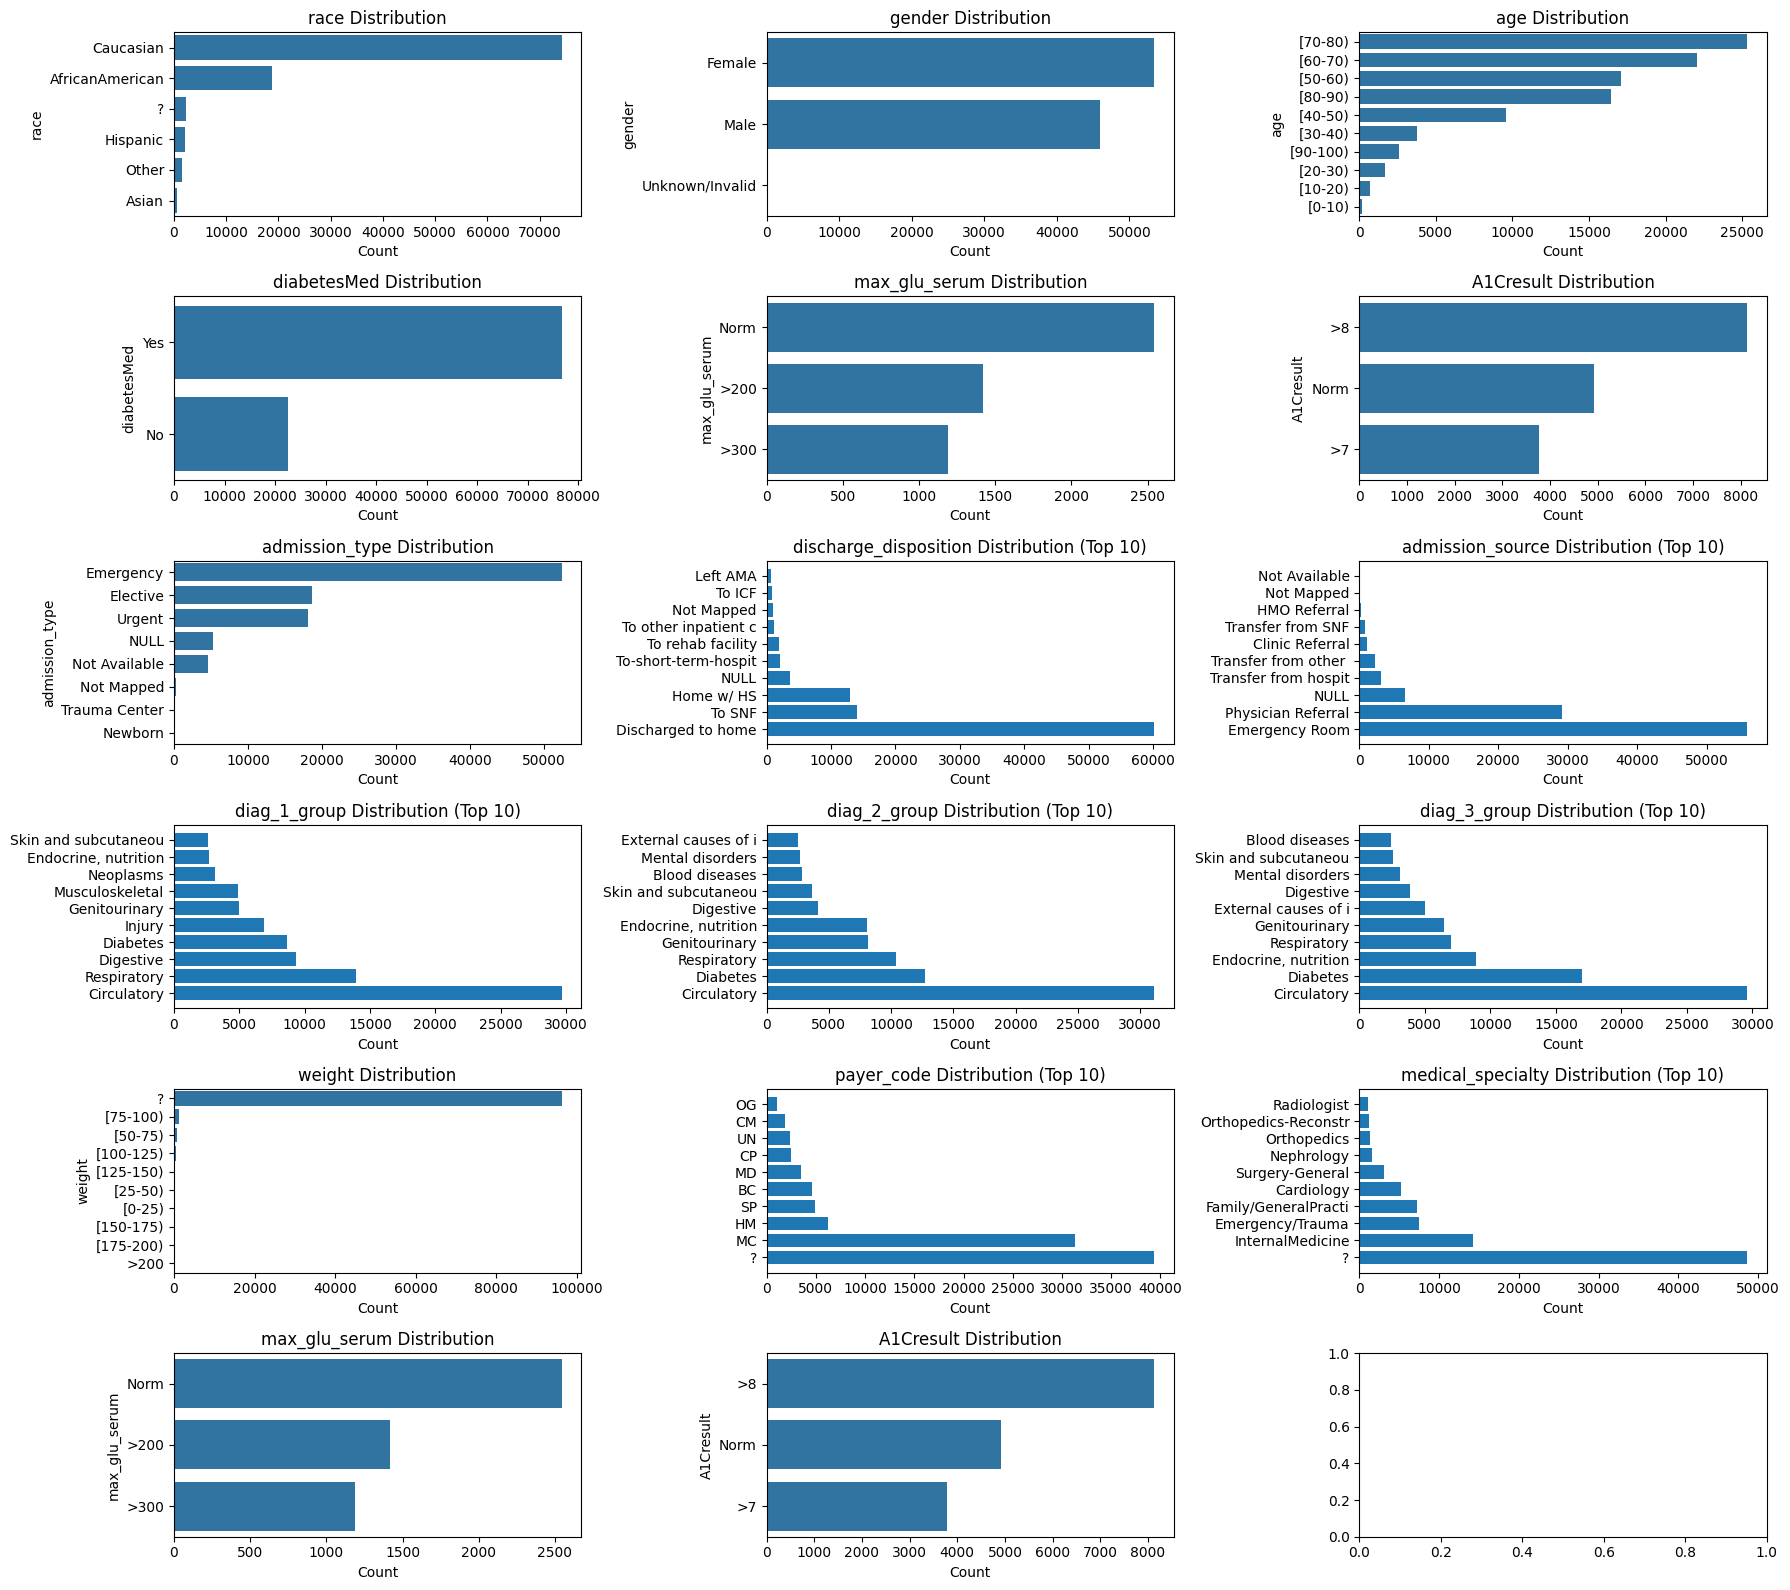

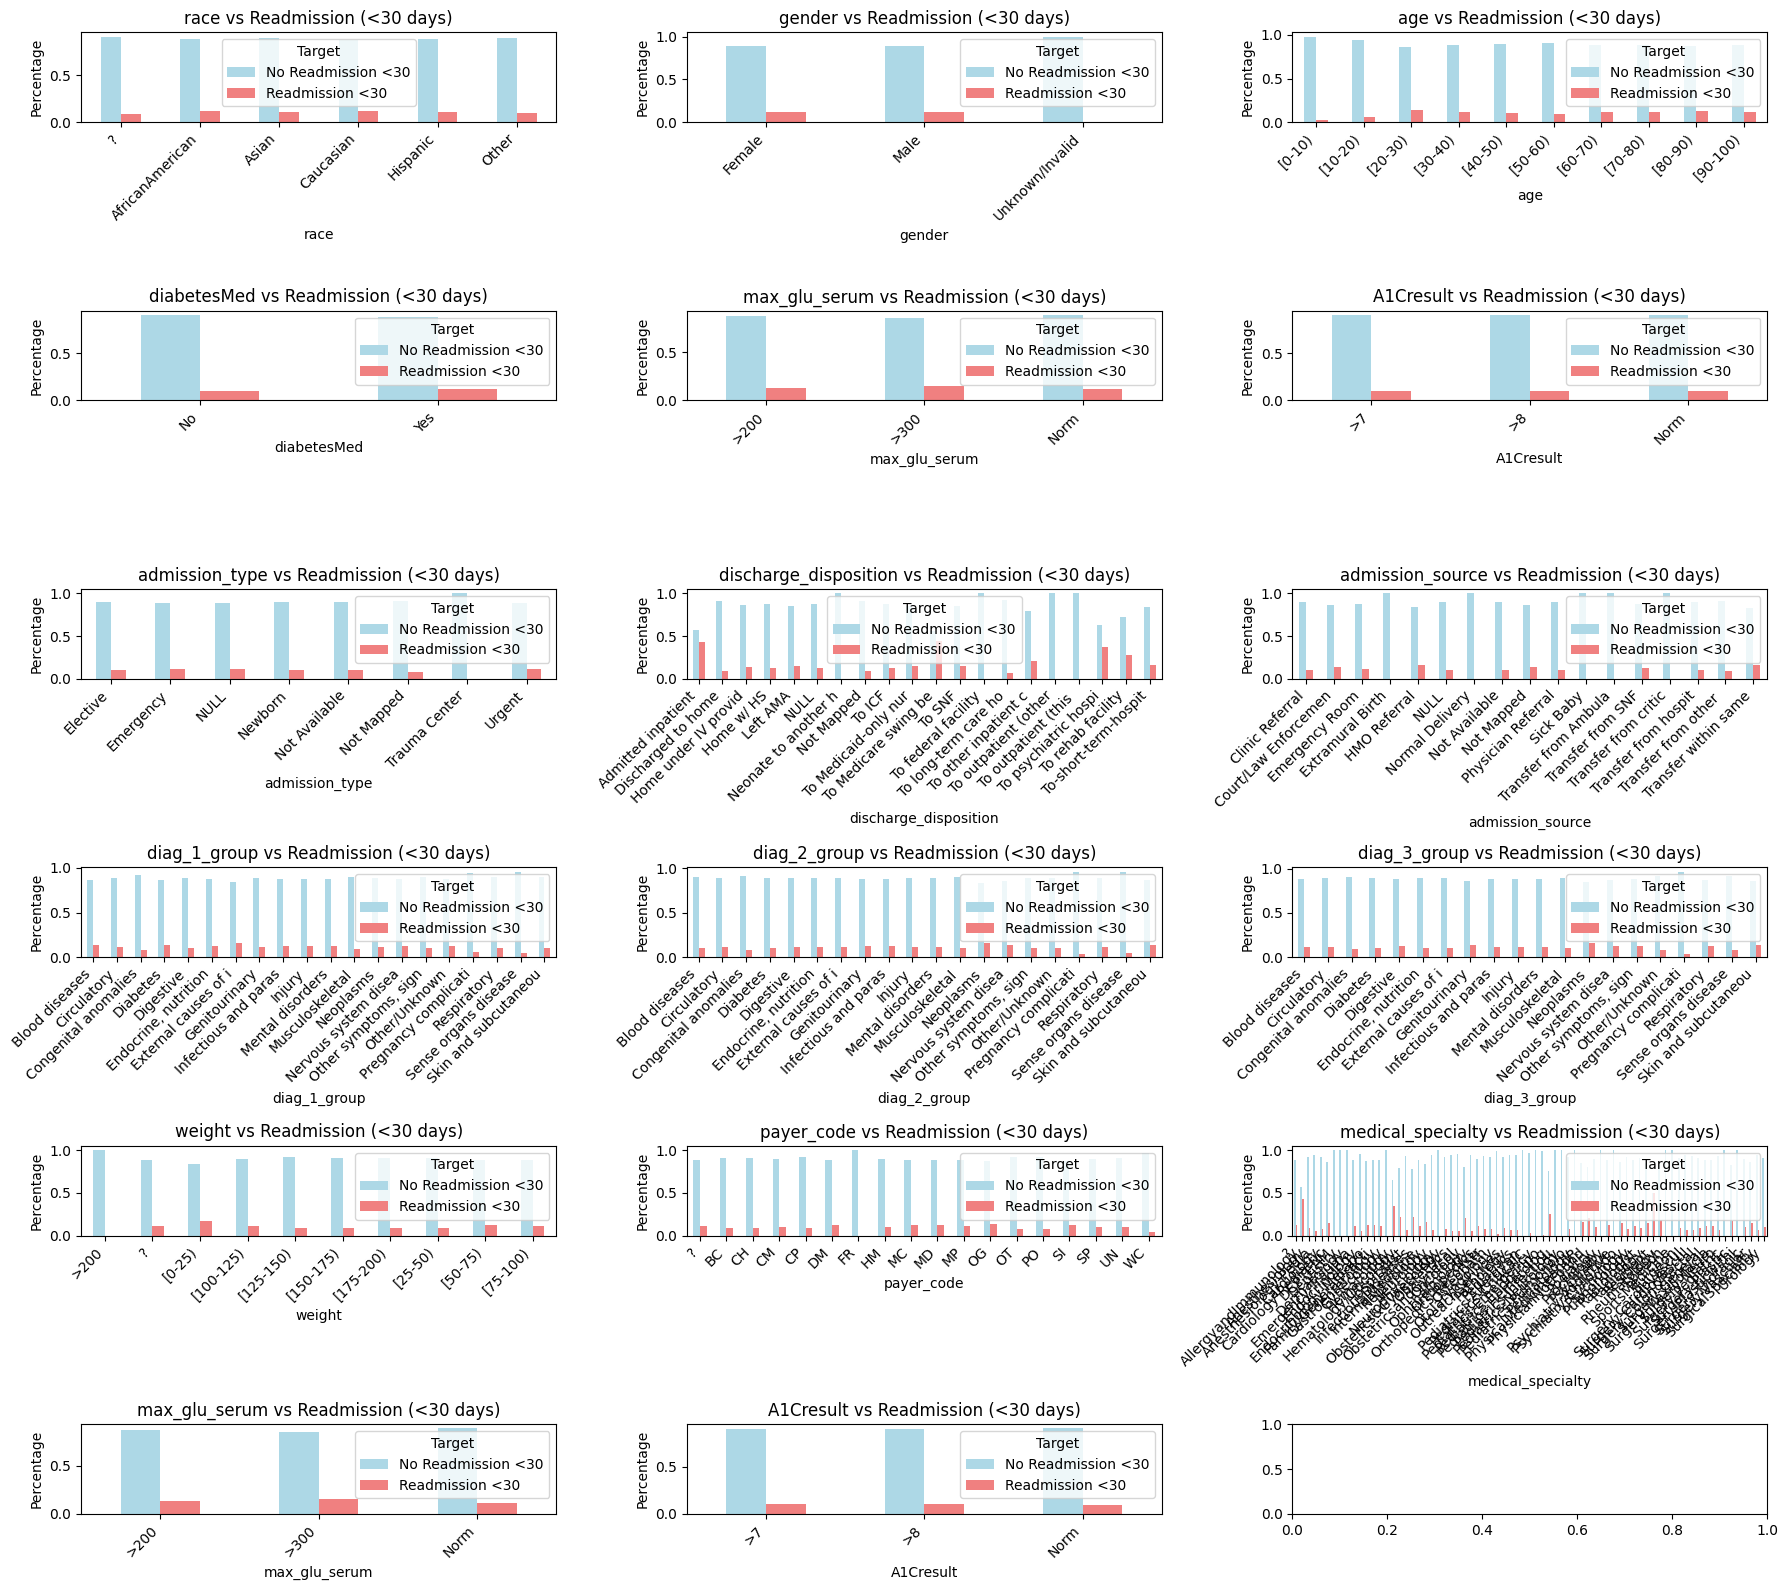


UNIQUE VALUES IN KEY CATEGORICAL COLUMNS:
  race: 6 unique values
    Values: ['Caucasian', 'AfricanAmerican', '?', 'Other', 'Asian', 'Hispanic']
  gender: 3 unique values
    Values: ['Female', 'Male', 'Unknown/Invalid']
  age: 10 unique values
    Values: ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
  diabetesMed: 2 unique values
    Values: ['No', 'Yes']
  max_glu_serum: 3 unique values
    Values: [nan, '>300', 'Norm', '>200']
  A1Cresult: 3 unique values
    Values: [nan, '>7', '>8', 'Norm']
  admission_type: 8 unique values
    Values: ['NULL', 'Emergency', 'Urgent', 'Elective', 'Newborn', 'Not Available', 'Not Mapped', 'Trauma Center']
  discharge_disposition: 20 unique values
  admission_source: 17 unique values
  diag_1_group: 20 unique values
  diag_2_group: 20 unique values
  diag_3_group: 20 unique values
  weight: 10 unique values
    Values: ['?', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)', '[

In [16]:
def analyze_categorical_variables(df, target_col='readmitted_binary'):
    """Analyze categorical variables for modeling insights"""
    print("\n" + "="*50)
    print("CATEGORICAL VARIABLES ANALYSIS")
    print("="*50)
    
    # Identify categorical columns (exclude target)
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    categorical_cols = [col for col in categorical_cols if col not in ['readmitted', target_col]]
    
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    
    # Analyze key categorical variables for modeling
    key_categorical = ['race', 'gender', 'age', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'admission_type', 'discharge_disposition', 
    'admission_source', 'diag_1_group', 'diag_2_group', 'diag_3_group', 'weight', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult']
    
    # Distribution plots
    fig, axes = plt.subplots(6, 3, figsize=(18, 16))
    axes = axes.ravel()
    
    for i, col in enumerate(key_categorical):
        if col in df.columns and i < len(axes):
            value_counts = df[col].value_counts()
            
            if len(value_counts) <= 15:  # Only plot if not too many categories
                sns.countplot(data=df, y=col, ax=axes[i], order=value_counts.index[:10])
                axes[i].set_title(f'{col} Distribution')
                axes[i].set_xlabel('Count')
            else:
                # For columns with many categories, show top 10
                top_values = value_counts.head(10)
                axes[i].barh(range(len(top_values)), top_values.values)
                axes[i].set_yticks(range(len(top_values)))
                axes[i].set_yticklabels(top_values.index)
                axes[i].set_title(f'{col} Distribution (Top 10)')
                axes[i].set_xlabel('Count')
                            # Truncate x-tick labels to 20 characters
                yticks = axes[i].get_yticklabels()
                axes[i].set_yticklabels([tick.get_text()[:20] for tick in yticks])

    
    plt.tight_layout()
    plt.show()
    
    # Relationship with BINARY target variable (<30 days readmission)
    fig, axes = plt.subplots(6, 3, figsize=(18, 16))
    axes = axes.ravel()
    
    for i, col in enumerate(key_categorical):
        if col in df.columns and i < len(axes):
            # Create crosstab showing readmission rates by category (binary)
            crosstab = pd.crosstab(df[col], df[target_col], normalize='index') 
            crosstab.plot(kind='bar', ax=axes[i], 
                         color=['lightblue', 'lightcoral'])
            axes[i].set_title(f'{col} vs Readmission (<30 days)')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Percentage')
            axes[i].legend(['No Readmission <30', 'Readmission <30'], title='Target')
            axes[i].tick_params(axis='x', rotation=45)
            # Truncate x-tick labels to 20 characters
            xticks = axes[i].get_xticklabels()
            axes[i].set_xticklabels([tick.get_text()[:20] for tick in xticks], rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print unique values for modeling consideration
    print("\nUNIQUE VALUES IN KEY CATEGORICAL COLUMNS:")
    for col in key_categorical:
        if col in df.columns:
            unique_count = df[col].nunique()
            print(f"  {col}: {unique_count} unique values")
            if unique_count <= 10:
                print(f"    Values: {df[col].unique().tolist()}")
    
    return categorical_cols

# Run categorical analysis
if df is not None:
    categorical_features = analyze_categorical_variables(df)

#### Categorical Features Analysis notes

- The majority of patients are Caucasian, followed by African American and Hispanic. 

- Most patients fall into older age groups, particularly those above middle age, which is consistent with the higher prevalence of diabetes among older adults. 

- The most common admission type is emergency, indicating that many patients are entering the hospital due to acute or unplanned health events rather than scheduled care.

- A notably high proportion of readmitted patients were discharged to a Medicare swing bed, suggesting that patients transitioning to skilled nursing care may be at elevated risk for early readmission.

- Most Diagnosis codes are circulatory, diabetes related and respitory. With the readmitted population, neoplasms are common for secondary and third diagnosis.

- Most patients had A1C values >8, indicating poorly controlled diabetes, while the majority had normal maximum glucose serum levels

### Medication Features analysis

There are many medication features that indicate whether a drug was prescribed to the patient or whether was change in dosage. Values: up if the dosage was increased during the encounter, down if the dosage was decreased, steady if the dosage did not change, and no if the drug was not prescribed. We will use only medications that have least 1000 patients to reduce noise. 


MEDICATION ANALYSIS
Top Medication Usage (patients who received each medication):
  insulin: 52,964 patients (53.32%)
  metformin: 19,844 patients (19.98%)
  glipizide: 12,531 patients (12.61%)
  glyburide: 10,523 patients (10.59%)
  pioglitazone: 7,255 patients (7.30%)
  rosiglitazone: 6,304 patients (6.35%)
  glimepiride: 5,122 patients (5.16%)
  repaglinide: 1,518 patients (1.53%)

Medication Impact on <30 Day Readmission:
  insulin: Used 12.4% vs Not Used 10.2% (Diff: +2.2%)
  metformin: Used 9.8% vs Not Used 11.8% (Diff: -2.0%)
  glipizide: Used 11.5% vs Not Used 11.4% (Diff: +0.2%)
  glyburide: Used 10.7% vs Not Used 11.5% (Diff: -0.7%)
  pioglitazone: Used 10.6% vs Not Used 11.4% (Diff: -0.8%)
  rosiglitazone: Used 10.5% vs Not Used 11.4% (Diff: -0.9%)
  glimepiride: Used 10.3% vs Not Used 11.4% (Diff: -1.1%)
  repaglinide: Used 13.5% vs Not Used 11.4% (Diff: +2.2%)


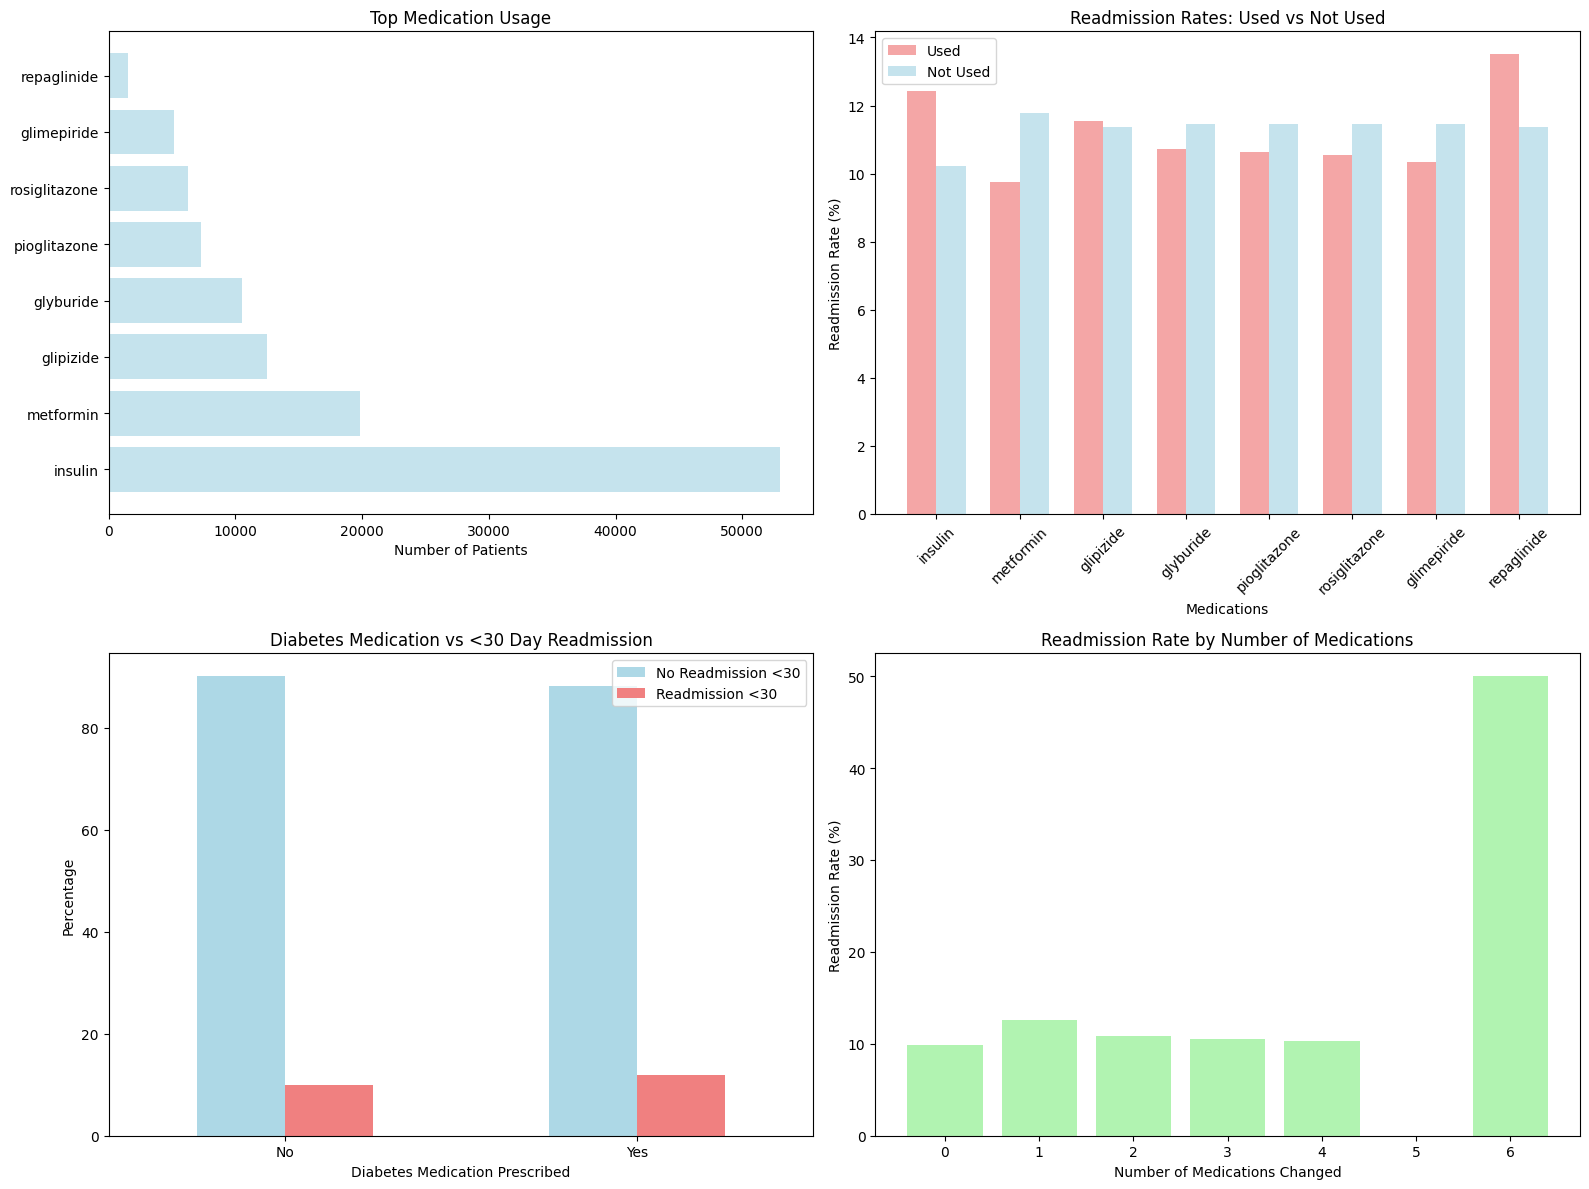

In [33]:
def analyze_medications(df, target_col='readmitted_binary'):
    """Analyze diabetes medications for modeling insights"""
    print("\n" + "="*50)
    print("MEDICATION ANALYSIS")
    print("="*50)
    
    # Identify medication columns
    medication_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                       'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                       'miglitol', 'troglitazone', 'tolazamide', 'examide',
                       'citoglipton', 'insulin']
    
    # Count medication usage (any change from 'No')
    medication_usage = {}
    for med in medication_cols:
        if med in df.columns:
            usage_count = (df[med] != 'No').sum()
            medication_usage[med] = usage_count
    
    # Sort by usage and filter medications with reasonable usage
    sorted_meds = sorted(medication_usage.items(), key=lambda x: x[1], reverse=True)
    top_meds = [(med, count) for med, count in sorted_meds if count > 1000]  # At least 1000 patients
    
    print("Top Medication Usage (patients who received each medication):")
    for med, count in top_meds:
        percentage = (count / len(df)) * 100
        print(f"  {med}: {count:,} patients ({percentage:.2f}%)")
    
    # Medication vs readmission analysis
    print(f"\nMedication Impact on <30 Day Readmission:")
    med_impact = []
    for med, count in top_meds:
        # Calculate readmission rates
        med_used = df[df[med] != 'No'][target_col].mean() * 100
        med_not_used = df[df[med] == 'No'][target_col].mean() * 100
        difference = med_used - med_not_used
        
        med_impact.append((med, med_used, med_not_used, difference))
        print(f"  {med}: Used {med_used:.1f}% vs Not Used {med_not_used:.1f}% (Diff: {difference:+.1f}%)")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top medication usage
    meds, counts = zip(*top_meds[:8])  # Top 8
    axes[0,0].barh(meds, counts, color='lightblue', alpha=0.7)
    axes[0,0].set_xlabel('Number of Patients')
    axes[0,0].set_title('Top Medication Usage')
    
    # Medication impact on readmission
    meds_impact, used_rates, not_used_rates, differences = zip(*med_impact[:8])
    x = range(len(meds_impact))
    width = 0.35
    
    axes[0,1].bar([i - width/2 for i in x], used_rates, width, label='Used', alpha=0.7, color='lightcoral')
    axes[0,1].bar([i + width/2 for i in x], not_used_rates, width, label='Not Used', alpha=0.7, color='lightblue')
    axes[0,1].set_xlabel('Medications')
    axes[0,1].set_ylabel('Readmission Rate (%)')
    axes[0,1].set_title('Readmission Rates: Used vs Not Used')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(meds_impact, rotation=45)
    axes[0,1].legend()
    
    # Overall diabetes medication analysis
    if 'diabetesMed' in df.columns:
        diabetes_crosstab = pd.crosstab(df['diabetesMed'], df[target_col], normalize='index') * 100
        diabetes_crosstab.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'lightcoral'])
        axes[1,0].set_title('Diabetes Medication vs <30 Day Readmission')
        axes[1,0].set_xlabel('Diabetes Medication Prescribed')
        axes[1,0].set_ylabel('Percentage')
        axes[1,0].legend(['No Readmission <30', 'Readmission <30'])
        axes[1,0].tick_params(axis='x', rotation=0)
    
    # Medication count analysis
    df['med_count'] = 0
    for med in medication_cols:
        if med in df.columns:
            df['med_count'] += (df[med] != 'No').astype(int)
    
    med_count_crosstab = df.groupby('med_count')[target_col].mean() * 100
    axes[1,1].bar(med_count_crosstab.index, med_count_crosstab.values, color='lightgreen', alpha=0.7)
    axes[1,1].set_xlabel('Number of Medications Changed')
    axes[1,1].set_ylabel('Readmission Rate (%)')
    axes[1,1].set_title('Readmission Rate by Number of Medications')
    
    plt.tight_layout()
    plt.show()
    
    return top_meds, med_impact

# Run medication analysis
if df is not None:
    medication_patterns, medication_impact = analyze_medications(df)

Medication Usage and Readmission Rate Analysis:
Note: Filter of >=100 patients recommended for statistical reliability
(Small sample sizes may show misleading differences)

metformin: 19,844 patients, difference: -2.0%
repaglinide: 1,518 patients, difference: +2.2%
nateglinide: 689 patients, difference: +0.2%
chlorpropamide: 85 patients, difference: -5.5%
glimepiride: 5,122 patients, difference: -1.1%
acetohexamide: 1 patients, difference: -11.4%
glipizide: 12,531 patients, difference: +0.2%
glyburide: 10,523 patients, difference: -0.7%
tolbutamide: 21 patients, difference: -6.6%
pioglitazone: 7,255 patients, difference: -0.8%
rosiglitazone: 6,304 patients, difference: -0.9%
acarbose: 305 patients, difference: -2.2%
miglitol: 38 patients, difference: -0.9%
troglitazone: 3 patients, difference: -11.4%
tolazamide: 39 patients, difference: -3.7%
insulin: 52,964 patients, difference: +2.2%


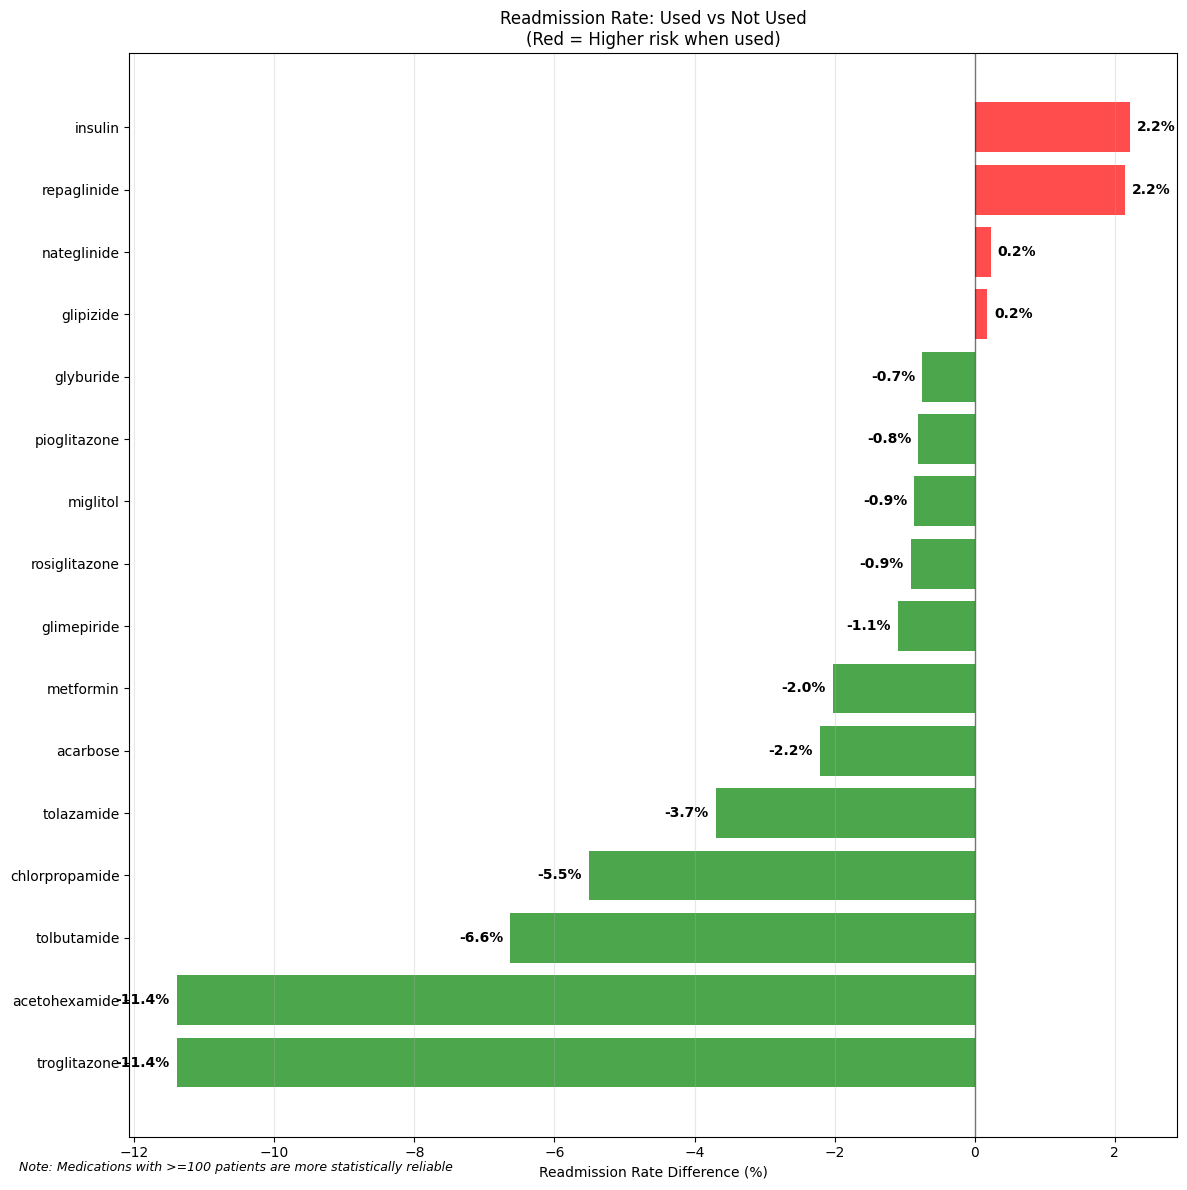


Summary: 10 medications with >=100 patients
         6 medications with <100 patients


In [14]:
# =====================================
# MEDICATION READMISSION RATE DIFFERENCE CHART
# =====================================

def create_medication_readmission_chart(df, target_col='readmitted_binary'):
    """Create medication readmission rate difference chart"""
    
    # Medication columns
    medication_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                       'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                       'miglitol', 'troglitazone', 'tolazamide', 'examide',
                       'citoglipton', 'insulin']
    
    # Calculate readmission rate differences for ALL medications
    med_differences = []
    
    print("Medication Usage and Readmission Rate Analysis:")
    print("Note: Filter of >=100 patients recommended for statistical reliability")
    print("(Small sample sizes may show misleading differences)\n")
    
    for med in medication_cols:
        if med in df.columns:
            # Calculate usage for all medications
            used_count = (df[med] != 'No').sum()
            
            if used_count > 0:  # Only need at least 1 patient
                # Readmission rates
                med_used_rate = df[df[med] != 'No'][target_col].mean() * 100
                med_not_used_rate = df[df[med] == 'No'][target_col].mean() * 100
                difference = med_used_rate - med_not_used_rate
                
                # Track reliability status
                reliable = used_count >= 100
                
                med_differences.append((med, difference, used_count, reliable))
                print(f"{med}: {used_count:,} patients, difference: {difference:+.1f}%")
    
    # Sort by difference
    med_differences.sort(key=lambda x: x[1])
    
    # Prepare data for plotting
    medications, differences, counts, reliability = zip(*med_differences)
    
    # Create colors: red for positive (higher risk), green for negative (lower risk)
    colors = ['green' if diff < 0 else 'red' for diff in differences]
    
    # Create the chart
    plt.figure(figsize=(12, 12))
    bars = plt.barh(medications, differences, color=colors, alpha=0.7)
    
    # Formatting
    plt.xlabel('Readmission Rate Difference (%)')
    plt.title('Readmission Rate: Used vs Not Used\n(Red = Higher risk when used)')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for bar, diff, count, reliable in zip(bars, differences, counts, reliability):
        x_pos = diff + (0.1 if diff >= 0 else -0.1)
        plt.text(x_pos, bar.get_y() + bar.get_height()/2,
                f'{diff:.1f}%', ha='left' if diff >= 0 else 'right',
                va='center', fontweight='bold', fontsize=10)
    
    # Add note about statistical reliability
    plt.figtext(0.02, 0.02, "Note: Medications with >=100 patients are more statistically reliable", 
                fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.show()
    
    reliable_count = sum(1 for r in reliability if r)
    unreliable_count = len(reliability) - reliable_count
    
    print(f"\nSummary: {reliable_count} medications with >=100 patients")
    print(f"         {unreliable_count} medications with <100 patients")

if df is not None:
    create_medication_readmission_chart(df)

#### Medications Feature Analysis Notes
We examined the 18 diabetes-related medication features to understand their prevalence and association with 30-day readmission. Key findings include:
- Insulin was the most common (53.3%), followed by Metformin (20%)
- Insulin users had a 12.4% readmission rate versus 10.2% for non-user, suggesting insulin dependant patients are at higher risk
- Metformin stood out for its protective association: users had a 9.8% readmission rate vs 11.8% for non-users
- Patients with more medications changed or prescribed tended to have slightly higher readmission rates, reflecting overall disease complexity and treatment intensity.

### Data Understanding Analysis Summary

The dataset primarily consists of older adult patients, with a majority identifying as Caucasian and most hospital admissions occurring through emergency visits, reflecting acute health events. Key categorical features reveal that patients discharged to Medicare swing beds show elevated readmission rates, and common diagnoses include circulatory, diabetes-related, and respiratory conditions—with neoplasms more frequent in secondary or tertiary diagnoses among readmitted patients. Medication analysis highlights insulin as the most commonly prescribed drug (53.3%), with insulin users exhibiting higher readmission risk, while metformin use appears protective. Numerical features such as number of inpatient visits, emergency visits, total diagnoses, and medication count are strongly correlated with readmission risk. Most patients had short hospital stays (2–4 days), 0–2 prior inpatient visits, and typically managed 10–20 medications. Additionally, most patients had A1C values >8, indicating poorly controlled diabetes, while the majority had normal maximum glucose serum levels. These insights guided feature engineering and informed model design.

## Data Preparation & Feature Engineering

Weight, payer code, medical specialty have significant percentage of missing values. These are hard to be imputed for effective analysis so dropping those. For missing values of race, imputing them with "unknown". For missing values of diagnosis, imputing them "missing". For missing A1C result, imputing them with "No Test taken" and for missing max_glu_serum, imputing them with "No Test taken".

In [ ]:
# =====================================
# COMPREHENSIVE MISSING VALUES HANDLING
# =====================================

def handle_missing_values_comprehensive(df):
    """Comprehensive missing values handling"""
    print("\n" + "="*50)
    print("COMPREHENSIVE MISSING VALUES HANDLING")
    print("="*50)
    
    # Replace '?' with np.nan for true missing value detection
    df = df.replace('?', np.nan).copy()
    
    # Drop columns with excessive missing values (>90%)
    columns_to_drop = ['payer_code', 'weight', 'medical_specialty']
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    print(f"Dropped columns: {columns_to_drop}")
    
    # Handle categorical missing values
    df['race'] = df['race'].fillna('Unknown')
    df['A1Cresult'] = df['A1Cresult'].replace({np.nan: 'No test', 'None': 'No test'})
    df['max_glu_serum'] = df['max_glu_serum'].replace({np.nan: 'No test', 'None': 'No test'})
    
    # Handle diagnosis missing values
    for col in ['diag_1', 'diag_2', 'diag_3']:
        df[col] = df[col].fillna('Missing')
    
    # Handle any remaining categorical missing values for modeling
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col] = df[col].fillna('Unknown').astype(str)
    
    # Handle numerical missing values
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    
    # Verify no missing values remain
    missing_after = df.isnull().sum()
    if missing_after.sum() > 0:
        print("WARNING: Still have missing values:")
        print(missing_after[missing_after > 0])
    else:
        print("All missing values handled successfully")
    
    return df

# Apply comprehensive missing value handling
df = handle_missing_values_comprehensive(df)


COMPREHENSIVE MISSING VALUES HANDLING
Dropped columns: ['payer_code', 'weight', 'medical_specialty']
All missing values handled successfully


## Duplicate analysis
We want to see if there are multiple encounters for a patient


DUPLICATE ANALYSIS
Exact duplicate rows: 0
Duplicate patient numbers: 29,352
Unique patients: 69,988
Total encounters: 99,340
Average encounters per patient: 1.42
Patients with multiple encounters: 16,340
Patients with single encounter: 53,648


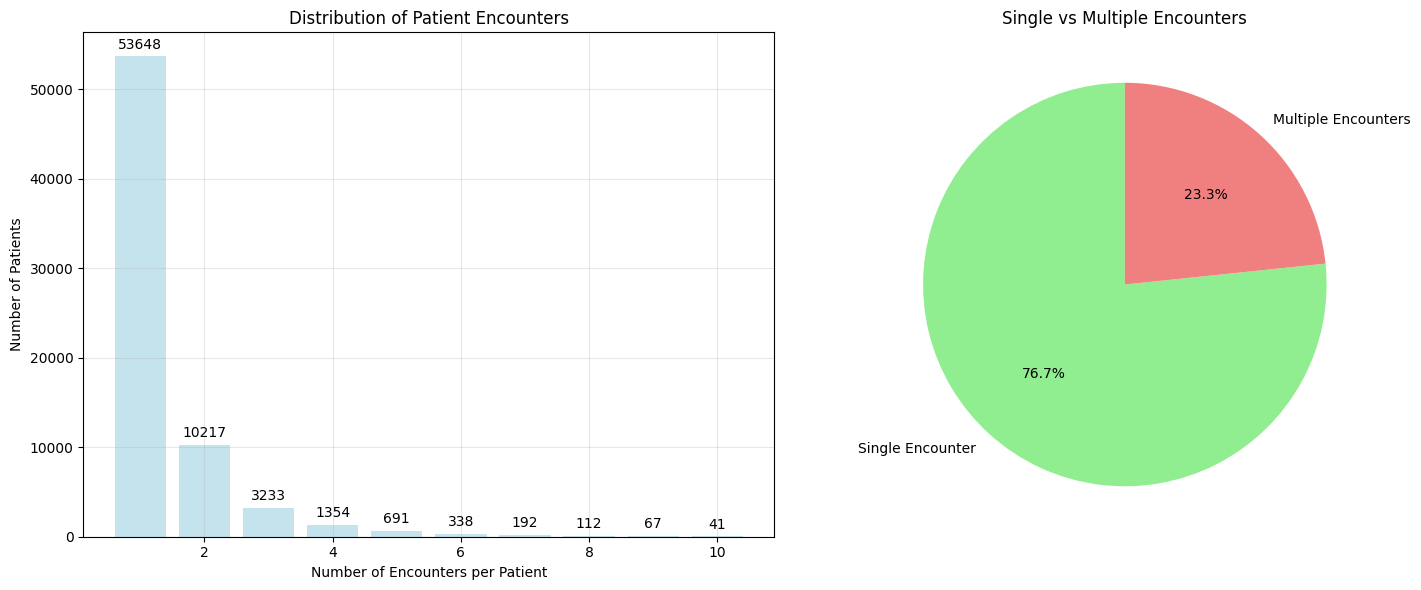


DATA QUALITY SUMMARY:
  23.3% of patients have multiple encounters
  No exact duplicate rows found


In [35]:
def analyze_duplicates(df):
    print("\n" + "="*50)
    print("DUPLICATE ANALYSIS")
    print("="*50)
    
    # Check for exact duplicates
    duplicate_rows = df.duplicated().sum()
    print(f"Exact duplicate rows: {duplicate_rows:,}")
    
    # Check for duplicate patient encounters
    if 'patient_nbr' in df.columns:
        duplicate_patients = df['patient_nbr'].duplicated().sum()
        unique_patients = df['patient_nbr'].nunique()
        
        print(f"Duplicate patient numbers: {duplicate_patients:,}")
        print(f"Unique patients: {unique_patients:,}")
        print(f"Total encounters: {len(df):,}")
        print(f"Average encounters per patient: {len(df)/unique_patients:.2f}")
        
        # Patients with multiple encounters
        patient_encounters = df['patient_nbr'].value_counts()
        multiple_encounters = (patient_encounters > 1).sum()
        
        print(f"Patients with multiple encounters: {multiple_encounters:,}")
        print(f"Patients with single encounter: {unique_patients - multiple_encounters:,}")
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Distribution of encounters per patient
        encounter_dist = patient_encounters.value_counts().sort_index()
        encounter_dist_limited = encounter_dist.head(10)  # Show up to 10 encounters
        
        axes[0].bar(encounter_dist_limited.index, encounter_dist_limited.values, 
                   color='lightblue', alpha=0.7)
        axes[0].set_xlabel('Number of Encounters per Patient')
        axes[0].set_ylabel('Number of Patients')
        axes[0].set_title('Distribution of Patient Encounters')
        axes[0].grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, v in enumerate(encounter_dist_limited.values):
            axes[0].text(encounter_dist_limited.index[i], v + max(encounter_dist_limited.values)*0.01, 
                        str(v), ha='center', va='bottom')
        
        # Single vs Multiple encounters
        single_vs_multiple = [unique_patients - multiple_encounters, multiple_encounters]
        labels = ['Single Encounter', 'Multiple Encounters']
        
        axes[1].pie(single_vs_multiple, labels=labels, autopct='%1.1f%%', 
                   colors=['lightgreen', 'lightcoral'], startangle=90)
        axes[1].set_title('Single vs Multiple Encounters')
        
        plt.tight_layout()
        plt.show()
        
        # Data quality summary
        print(f"\nDATA QUALITY SUMMARY:")
        if multiple_encounters > 0:
            multiple_pct = (multiple_encounters / unique_patients) * 100
            print(f"  {multiple_pct:.1f}% of patients have multiple encounters")
        
        if duplicate_rows > 0:
            print(f"  {duplicate_rows:,} exact duplicate rows found")
        else:
            print(f"  No exact duplicate rows found")
    
    return duplicate_rows, unique_patients if 'patient_nbr' in df.columns else None

# Run duplicate analysis
if df is not None:
    duplicates, unique_patients = analyze_duplicates(df)

In [36]:
# Pick only the first encounter for each patient with multiple encounters
if df is not None and unique_patients is not None:
    df = df.sort_values(by='encounter_id').drop_duplicates(subset='patient_nbr', keep='first').copy()
    print(f"\nFiltered dataset to first encounter for each patient. New row count: {len(df):,}")


Filtered dataset to first encounter for each patient. New row count: 69,988


In [37]:
# convert age to numeric for better analysis for ensemble models
age_map = {
    '[0-10)': 5,
    '[10-20)': 15,
    '[20-30)': 25,
    '[30-40)': 35,
    '[40-50)': 45,
    '[50-60)': 55,
    '[60-70)': 65,
    '[70-80)': 75,
    '[80-90)': 85,
    '[90-100)': 95
}

df['age_numeric'] = df['age'].map(age_map)

In [38]:
# Final dataset shape and summary
if df is not None:
    print(f"\nFinal dataset shape: {df.shape}")
    print("Final dataset summary:")
    print(df.describe(include='all').transpose())


Final dataset shape: (69988, 56)
Final dataset summary:
                            count unique                 top   freq  \
encounter_id              69988.0    NaN                 NaN    NaN   
patient_nbr               69988.0    NaN                 NaN    NaN   
race                        69988      6           Caucasian  52303   
gender                      69988      3              Female  37239   
age                         69988     10             [70-80)  17750   
admission_type_id         69988.0    NaN                 NaN    NaN   
discharge_disposition_id  69988.0    NaN                 NaN    NaN   
admission_source_id       69988.0    NaN                 NaN    NaN   
time_in_hospital          69988.0    NaN                 NaN    NaN   
num_lab_procedures        69988.0    NaN                 NaN    NaN   
num_procedures            69988.0    NaN                 NaN    NaN   
num_medications           69988.0    NaN                 NaN    NaN   
number_outpatient   

In [39]:
# save the cleaned dataset
df.to_csv('cleaned_diabetic_data.csv', index=False)

# Model Implementation

## Create & Define Enhanced Features for CatBoost 

In [40]:
def create_enhanced_features(df):
    """Creating new features to enhance model predictive power"""
    print("="*50)
    print("FEATURE ENGINEERING")
    print("="*50)
    
    df_enhanced = df.copy()
    
    # Healthcare utilization patterns
    df_enhanced['total_visits'] = (df_enhanced['number_outpatient'] + 
                                  df_enhanced['number_emergency'] + 
                                  df_enhanced['number_inpatient'])
    
    # Medical complexity scores
    df_enhanced['med_complexity'] = (df_enhanced['num_medications'] * 
                                   df_enhanced['number_diagnoses'])
    
    # Length of stay relative to procedures
    df_enhanced['stay_per_procedure'] = (df_enhanced['time_in_hospital'] / 
                                       (df_enhanced['num_procedures'] + 1))
    
    # Age-based risk categories
    df_enhanced['high_risk_age'] = (df_enhanced['age_numeric'] >= 75).astype(int)
    
    # Hospital intensity score
    df_enhanced['hospital_intensity'] = (df_enhanced['num_lab_procedures'] + 
                                       df_enhanced['num_procedures'] + 
                                       df_enhanced['num_medications'])
    
    print(f"Enhanced features created. Dataset shape: {df_enhanced.shape}")
    return df_enhanced

def prepare_feature_sets(df_enhanced):
    """Define and prepare feature sets for modeling"""
    
    # Numerical features (original + enhanced)
    numerical_features = [
        'time_in_hospital', 'num_lab_procedures', 'num_procedures',
        'num_medications', 'number_outpatient', 'number_emergency',
        'number_inpatient', 'number_diagnoses', 'age_numeric', 'med_count',
        # Enhanced numerical features
        'total_visits', 'med_complexity', 'stay_per_procedure', 
        'hospital_intensity'
    ]
    
    # Categorical features (original + enhanced)
    categorical_features = [
        'race', 'gender', 'admission_type', 'discharge_disposition',
        'admission_source', 'diag_1_group', 'diag_2_group', 'diag_3_group',
        'diabetesMed', 'max_glu_serum', 'A1Cresult', 'change',
        'insulin', 'metformin', 'glipizide', 'glyburide', 'pioglitazone',
        'high_risk_age'  # Enhanced categorical
    ]
    
    # Combine all features
    feature_columns = numerical_features + categorical_features
    
    # Prepare feature matrix and target
    X = df_enhanced[feature_columns].copy()
    y = df_enhanced['readmitted_binary'].copy()
    
    print(f"Feature preparation complete")
    print(f"Total features: {len(feature_columns)}")
    print(f"Numerical: {len(numerical_features)}, Categorical: {len(categorical_features)}")
    print(f"Original class distribution: {Counter(y)}")
    
    return X, y, feature_columns

### CATBOOST MODEL IMPLEMENTATION - Function

In [41]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

def create_catboost_model_with_class_weights():
    """Create CatBoost model using class weights to handle imbalance"""
    print("\n" + "="*50)
    print("CATBOOST MODEL CONFIGURATION (Class Weights)")
    print("="*50)

    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        depth=7,
        l2_leaf_reg=3,
        random_strength=1,
        eval_metric='AUC',
        early_stopping_rounds=100,
        task_type='CPU',
        random_seed=42,
        verbose=200,
        bootstrap_type='Bernoulli',
        subsample=0.8,
        colsample_bylevel=0.8,
        class_weights=[1, 5]  # Assumes class 0 is majority and class 1 is minority
    )

    print("CatBoost model configured with class weights")
    return model


def train_and_evaluate_model(X, y):
    print("\n" + "="*50)
    print("MODEL TRAINING AND EVALUATION")
    print("="*50)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training: {X_train.shape}, Test: {X_test.shape}")
    print(f"Train class distribution: {Counter(y_train)}")
    print(f"Test class distribution: {Counter(y_test)}")
    
    # Detect categorical features
    cat_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"Categorical features: {cat_features}")
    
    # Create and train model
    model = create_catboost_model_with_class_weights()
    
    print("\nTraining model...")
    model.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_features, plot=False)
    
    # Predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Threshold sweep
    print("\n" + "="*50)
    print("THRESHOLD SWEEP FOR OPTIMAL F1")
    print("="*50)
    best_f1, best_thresh = 0, 0.5
    for t in np.linspace(0.1, 0.9, 17):
        preds_t = (y_pred_proba > t).astype(int)
        f1 = f1_score(y_test, preds_t)
        print(f"Threshold {t:.2f} → F1-score: {f1:.4f}")
        if f1 > best_f1:
            best_f1, best_thresh = f1, t

    print(f"\n→ Optimal Threshold: {best_thresh:.2f} (F1={best_f1:.4f})")
    
    # Final predictions using best threshold
    final_preds = (y_pred_proba > best_thresh).astype(int)
    accuracy = accuracy_score(y_test, final_preds)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n" + "="*40)
    print("FINAL MODEL PERFORMANCE @ OPTIMAL THRESHOLD")
    print("="*40)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"F1 Score:  {best_f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")

    print(f"\nClassification Report:")
    print(classification_report(y_test, final_preds))

    return model, X_test, y_test, final_preds, y_pred_proba, best_thresh


### Plot Model Results - Function 

In [42]:
def plot_model_results(y_test, y_pred, y_pred_proba, model, X):
    """Create evaluation plots without prediction distribution"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('CatBoost + Model Evaluation', fontsize=16, fontweight='bold')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.3f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Feature Importance (top 15 for encoded features)
    feature_importance = model.get_feature_importance()
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False).head(15)
    
    sns.barplot(data=importance_df, y='feature', x='importance', ax=axes[2])
    axes[2].set_title('Top 15 Feature Importance')
    axes[2].tick_params(axis='y', labelsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

### CatBoost Model Execution 

IMPLEMENTING CATBOOST SOLUTION with Threshold Sweep
FEATURE ENGINEERING
Enhanced features created. Dataset shape: (69988, 61)
Feature preparation complete
Total features: 32
Numerical: 14, Categorical: 18
Original class distribution: Counter({0: 63704, 1: 6284})

MODEL TRAINING AND EVALUATION
Training: (55990, 32), Test: (13998, 32)
Train class distribution: Counter({0: 50963, 1: 5027})
Test class distribution: Counter({0: 12741, 1: 1257})
Categorical features: ['race', 'gender', 'admission_type', 'discharge_disposition', 'admission_source', 'diag_1_group', 'diag_2_group', 'diag_3_group', 'diabetesMed', 'max_glu_serum', 'A1Cresult', 'change', 'insulin', 'metformin', 'glipizide', 'glyburide', 'pioglitazone']

CATBOOST MODEL CONFIGURATION (Class Weights)
CatBoost model configured with class weights

Training model...
0:	test: 0.5985380	best: 0.5985380 (0)	total: 47.4ms	remaining: 47.3s
200:	test: 0.6449290	best: 0.6464665 (152)	total: 8.23s	remaining: 32.7s
Stopped by overfitting detecto

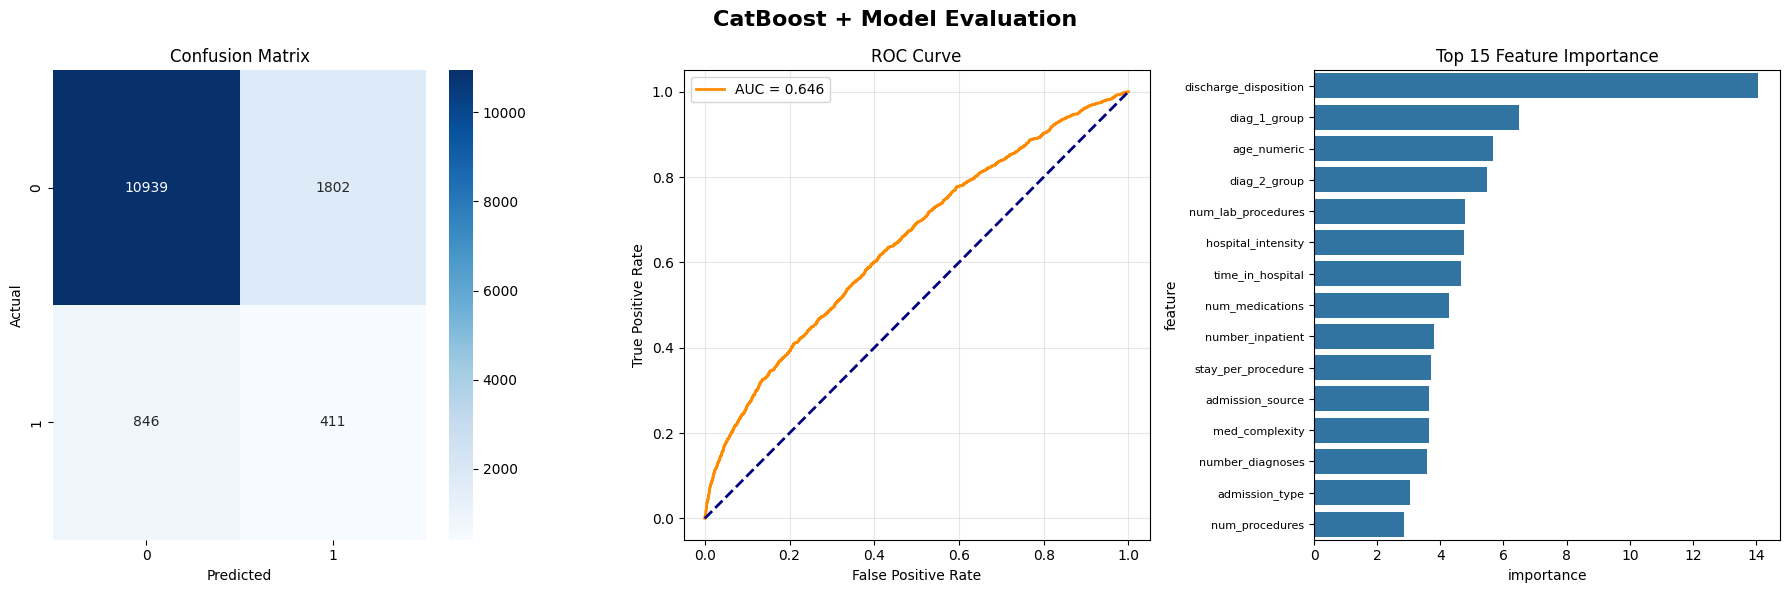

In [43]:
print("IMPLEMENTING CATBOOST SOLUTION with Threshold Sweep")

# Step 1: Feature Engineering
df_enhanced = create_enhanced_features(df)
X, y, feature_columns = prepare_feature_sets(df_enhanced)

# Step 2: Train and Evaluate Model with Threshold Sweep
model, X_test, y_test, final_preds, y_pred_proba, best_thresh = train_and_evaluate_model(X, y)

# Step 3: Visualization (use final_preds instead of y_pred)
importance_df = plot_model_results(y_test, final_preds, y_pred_proba, model, X)



In [46]:
# save the model and see its size
import joblib
model_filename = 'readmissiondiabetic_catboost.pkl'
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename} with size {os.path.getsize(model_filename) / 1024:.2f} KB")

Model saved to readmissiondiabetic_catboost.pkl with size 885.13 KB


In [47]:
# Inference run time
import time
import numpy as np

sample_input = X_test.iloc[0:1]  # single patient row

start_time = time.time()
_ =model.predict(sample_input)
inference_time_ms = (time.time() - start_time) * 1000
print(f"Inference time: {inference_time_ms:.2f} ms")

Inference time: 4.73 ms


# Deployment Plan

## Usage: Clinical Workflow Integration
The objective is to deploy the trained CatBoost model to predict whether a diabetic patient will be readmitted to the hospital within 30 days of discharge. This model is designed for real-time use at the point of discharge. As part of hospital workflow:

When a patient is being discharged, the model is automatically invoked to evaluate their risk of readmission. The risk score will be used to trigger follow-up protocols under a "High Risk" readmission flag, such as:

- Early follow-up appointment scheduling

- Care coordinator outreach or check-ins

- Enhanced medication adherence support

- Enrollment in telehealth or remote monitoring programs

As such the model will be invoked via an API that is integrated into an EHR like Epic, via FHIR-based SMART on FHIR integration.

Input
-----

The API expects a POST request with a JSON payload of structured patient data at discharge, including:

```
{
  "gender": "Male",
  "age": "[70-80)",
  "admission_type_id": 1,
  "discharge_disposition_id": 1,
  "number_inpatient": 2,
  "number_emergency": 1,
  "number_diagnoses": 9,
  "A1Cresult": ">8",
  "insulin": "No",
  "diabetesMed": "Yes",
  ...
}
```


Output
------
The API will return
```
{
  "readmission_risk": 1,
  "probability": 0.78,
  "top_features": ["discharge_disposition", "insulin", "number_inpatient"]
}
```
The probability helps understand the readmission risk better and top features help explain why a patient is high risk

## Architecture
We are choosing an AWS-based deployment strategy as our infrastructure already resides in the cloud.

Given the small size of the trained CatBoost model and its low inference latency (~6 ms), a FastAPI-based RESTful API is a lightweight, efficient, and maintainable deployment choice. This approach offers flexibility without the added complexity or cost of a fully managed service like SageMaker.

Key Components:

- Model: Trained CatBoost classifier with integrated feature preprocessing.
- Interface: RESTful API via FastAPI.
- Containerization: API and the model are packaged into a Docker container for portability and consistency across environments.
- Deployment Platform: Hosted on AWS ECS (Elastic Container Service) using Fargate, which provides serverless container orchestration with automatic scaling and no infrastructure management.
- Monitoring & Logging: CloudWatch logs and AWS X-Ray (optional) for tracing requests and monitoring inference latency.
- Networking: Deployed behind an Application Load Balancer with HTTPS support and authentication middleware (e.g., OAuth2/JWT) for secure access.
- S3: Used to store training and testing datasets

![Alt text](DeploymentDiagram.io.jpg)

## Model Deployment & Iteration
- The trained model is serialized using pickle and saved as a .pkl file.

- On application startup, the FastAPI app loads the model from disk using joblib or pickle.

- The API container includes all preprocessing logic to ensure consistency with the training pipeline.

- CI/CD deployment using Docker + AWS ECS ensures that updates to the model or preprocessing can be redeployed seamlessly.

Future Enhancements
--------------------

- Incorporate model drift detection and retraining pipeline using updated EHR data.

- Monitor real-world performance via outcome tracking (e.g., did flagged patients actually get readmitted?).

- Enable versioning to allow rollback/testing of new model iterations.


## Security and Compliance


- All traffic is routed over HTTPS

- PHI data is minimized, BAA with AWS in place to protect any PHI Storage

- Model input/output payloads are encrypted in transit and at rest

- Access to the API is authenticated via OAuth2 or token-based mechanism

- Audit logging is enabled to track model requests and responses

- FHIR and HIPAA-aligned practices for healthcare interoperability and compliance